In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib
matplotlib.use('nbagg')
from matplotlib import pyplot as plt
%matplotlib widget
import pandas as pd

The beginning of this notebook is somewhat similar to `viz_segment6.ipynb` because it loads up the turning points and the hash codes.

In [ ]:
# Load the hash_master file
hash_df = pd.read_csv('../data/osstate/routes_hashes/hash_master.hashb', header=None, names=['wpf', 'wpt', 'hash'])
print(f"There are {len(hash_df)} rows")
hash_df.head()

In [ ]:
hash_unique = hash_df['hash'].unique()
print('Number of unique hashes:', len(hash_unique))

In [ ]:
# Rank the hashes by the number of times they appear
hash_counts = hash_df['hash'].value_counts()
hash_counts = hash_counts.sort_values(ascending=False)
hash_counts.head(10)


In [ ]:
# Load the waypoints_master file
wp_df = pd.read_csv('../data/osstate/waypoints_master.csv')
wp_df.head()

# Stitching for CONUS

In [14]:
region = 'conus'
def get_region_bounds(region: str) -> tuple:
    # Get the geographical boundaries for the map 
    if region=='conus':
        # Contiguous United States
        lat_bounds = [23, 51]
        lon_bounds = [-130, -65]
    elif region=='europe':
        # Europe, from Portugal to Greece, not including Russia
        lat_bounds = [34, 72]        
        lon_bounds = [-32, 40]
    else:
        raise ValueError(f"Region {region} not recognized. Use 'conus' or 'europe'.")
    
    return lat_bounds, lon_bounds

lat_bounds, lon_bounds = get_region_bounds(region)

In [15]:
busiest_airports = {
    "KATL": {"name": "Hartsfield-Jackson Atlanta International Airport", "lat": 33.6407, "lon": -84.4277},
    "KLAX": {"name": "Los Angeles International Airport", "lat": 33.9416, "lon": -118.4085},
    "KORD": {"name": "Chicago O'Hare International Airport", "lat": 41.9742, "lon": -87.9073},
    "KDFW": {"name": "Dallas/Fort Worth International Airport", "lat": 32.8998, "lon": -97.0403},
    "KDEN": {"name": "Denver International Airport", "lat": 39.8561, "lon": -104.6737},
    "KJFK": {"name": "John F. Kennedy International Airport", "lat": 40.6413, "lon": -73.7781},
    "KSFO": {"name": "San Francisco International Airport", "lat": 37.7749, "lon": -122.4194},
    "KSEA": {"name": "Seattle-Tacoma International Airport", "lat": 47.6062, "lon": -122.3321},
    "KLAS": {"name": "Las Vegas McCarran International Airport", "lat": 36.0840, "lon": -115.1537},
    "KMCO": {"name": "Orlando International Airport", "lat": 28.4312, "lon": -81.3081},
    "KPHX": {"name": "Phoenix Sky Harbor International Airport", "lat": 33.4342, "lon": -112.0116},
    "KMIA": {"name": "Miami International Airport", "lat": 25.7959, "lon": -80.2870},
    "KIAH": {"name": "George Bush Intercontinental Airport", "lat": 29.9902, "lon": -95.3368},
    "KMSP": {"name": "Minneapolis-Saint Paul International Airport", "lat": 44.8833, "lon": -93.2040},
    "KBOS": {"name": "Logan International Airport", "lat": 42.3656, "lon": -71.0096},
    "KDCA": {"name": "Ronald Reagan Washington National Airport", "lat": 38.8512, "lon": -77.0402},
    "KIAD": {"name": "Washington Dulles International Airport", "lat": 38.9531, "lon": -77.4565},
    "KPHL": {"name": "Philadelphia International Airport", "lat": 39.8744, "lon": -75.2424},
    "KBWI": {"name": "Baltimore/Washington International Thurgood Marshall Airport", "lat": 39.1754, "lon": -76.6684},
    "KSLC": {"name": "Salt Lake City International Airport", "lat": 40.7899, "lon": -111.9791},
    "KSAN": {"name": "San Diego International Airport", "lat": 32.7338, "lon": -117.1933},
    "KFLL": {"name": "Fort Lauderdale-Hollywood International Airport", "lat": 26.0726, "lon": -80.1527},
    "KTPA": {"name": "Tampa International Airport", "lat": 27.9755, "lon": -82.5332},
    "KPDX": {"name": "Portland International Airport", "lat": 45.5898, "lon": -122.5951},
    "KHOU": {"name": "William P. Hobby Airport", "lat": 29.6454, "lon": -95.2789},
    "KSTL": {"name": "St. Louis Lambert International Airport", "lat": 38.7490, "lon": -90.3748},
    "KSAT": {"name": "San Antonio International Airport", "lat": 29.5337, "lon": -98.4698},
    "KSJC": {"name": "Norman Y. Mineta San Jose International Airport", "lat": 37.3639, "lon": -121.9290},
    "KOAK": {"name": "Oakland International Airport", "lat": 37.7213, "lon": -122.2207},
    "KAUS": {"name": "Austin-Bergstrom International Airport", "lat": 30.1944, "lon": -97.6699},
    "KRDU": {"name": "Raleigh-Durham International Airport", "lat": 35.8801, "lon": -78.7880},
    "KSNA": {"name": "John Wayne Airport", "lat": 33.6757, "lon": -117.8682},
    "KMEM": {"name": "Memphis International Airport", "lat": 35.0421, "lon": -89.9792},
    "KSDF": {"name": "Louisville Muhammad Ali International Airport", "lat": 38.1741, "lon": -85.7360},
    "KCVG": {"name": "Cincinnati/Northern Kentucky International Airport", "lat": 39.0533, "lon": -84.6630},
    "KPIT": {"name": "Pittsburgh International Airport", "lat": 40.4914, "lon": -80.2329},
    "KMKE": {"name": "General Mitchell International Airport", "lat": 42.9475, "lon": -87.8966}
}


In [17]:
color_codes = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

In [ ]:
from stitcher import get_flow
import warnings
import cartopy.crs as ccrs
import cartopy.feature
warnings.filterwarnings("ignore", category=FutureWarning) # to get rid of pyproj warnings

from tqdm import tqdm
import mplcursors

def visualize_flows(region, hash_counts, hash_df, wp_df, n_first_hashes = 20):
    # Get the top n_plots hash values
    hash_values = hash_counts.head(n_first_hashes).index

    # Create a Cartopy PlateCarree projection
    projection = ccrs.PlateCarree()

    # Create a figure
    fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})

    lat_bounds, lon_bounds = get_region_bounds(region)

    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]])

    flows = []

    for i in tqdm(range(n_first_hashes)):
        res = get_flow(hash_counts, i, hash_df, wp_df, n_segments_to_sample = 100, region = region, eps=1e5)
        if res is None:
            continue # probably due to hashes outside of the region
        sm_start, sm_end = res # unpack the result
        flows.append((sm_start, sm_end))
        # print(f"Found flow {i}: {sm_start} -> {sm_end}")
        # Plot the great circle going through sm_start and sm_end
        color = color_codes[i % len(color_codes)]
        ax.plot([sm_start[1], sm_end[1]], [sm_start[0], sm_end[0]], color=color, linewidth=2, transform=ccrs.Geodetic(), label=f'F{i}')

    # Add map features
    ax.coastlines()
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    if region == 'conus':
        # Add state borders
        ax.add_feature(cartopy.feature.STATES, linestyle=':')
        plt.title(f'Top {n_first_hashes} flows for Contiguous United States identified by Zarya')
    elif region == 'europe':
        # Add country borders
        ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
        plt.title(f'Top {n_first_hashes} flows for Europe identified by Zarya')
    plt.tight_layout()
    # Set equal aspect ratio
    ax.set_aspect('equal', adjustable=None)
    # Show gridlines
    ax.gridlines(draw_labels=True)
    # Scatter plot the busiest airports
    for airport, data in busiest_airports.items():
        ax.scatter(data['lon'], data['lat'], color='blue', s=100, transform=ccrs.PlateCarree(), label=airport)
        ax.text(data['lon'], data['lat'], airport, transform=ccrs.PlateCarree(), fontsize=12, color='blue')
    # Add mplcursors to make it interactive
    cursor = mplcursors.cursor(hover=True)
    # Annotate with the legend label when hovering over a curve
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set_text(sel.artist.get_label())
    plt.legend()
    plt.show()

    return flows

# This line of code is to previsualize the top 128 flows, after which we can inspect and cluster the flows using both unsupervised
# methods and manually for best result. Comment out this code if the merge_instructions variable below has been created.
flows = visualize_flows('conus', hash_counts, hash_df, wp_df, n_first_hashes = 128)

In [ ]:
import os

# Create the directory if it doesn't exist
directory = 'results/stitch_cluster9'
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the flows to a file
with open('results/stitch_cluster9/flows.pkl', 'wb') as f:
    pickle.dump(flows, f)
    print('Flows saved to file')

# Merging subflows

In [2]:
# Load the flows from a file
import pickle
with open('results/stitch_cluster9/flows.pkl', 'rb') as f:
    flows = pickle.load(f)
    print('Flows loaded from file')

Flows loaded from file


In [38]:
from tqdm import tqdm
from stitcher import visvalingam_wyatt_merge_flows

merge_instructions = [
    (9,51,19,20,4), 
    (64, 120),
    (67, 110),
    (108, 17),
    (12, 46, 59, 79),
    (76, 0),
    (110, 92),
    (77, 3),
    (28, 84)
]

merged_flows = visvalingam_wyatt_merge_flows(merge_instructions, flows)
print(f'Merged {len(merge_instructions)} clusters into {len(merged_flows)} flows')

100%|██████████| 126/126 [00:00<00:00, 28173.70it/s]

Scanning instruction: (76, 0)
Flow 0 simplified from 4 to 4
Scanning instruction: (77, 3)
Flow 3 simplified from 4 to 4
Scanning instruction: (9, 51, 19, 20, 4)
Flow 4 simplified from 10 to 10
Scanning instruction: (12, 46, 59, 79)
Flow 12 simplified from 8 to 7
Scanning instruction: (108, 17)
Flow 17 simplified from 4 to 4
Scanning instruction: (28, 84)
Flow 28 simplified from 4 to 4
Scanning instruction: (64, 120)
Flow 64 simplified from 4 to 4
Scanning instruction: (67, 110)
Flow 67 simplified from 4 to 4
Scanning instruction: (110, 92)
Flow 92 simplified from 4 to 4
Merged 9 clusters into 113 flows


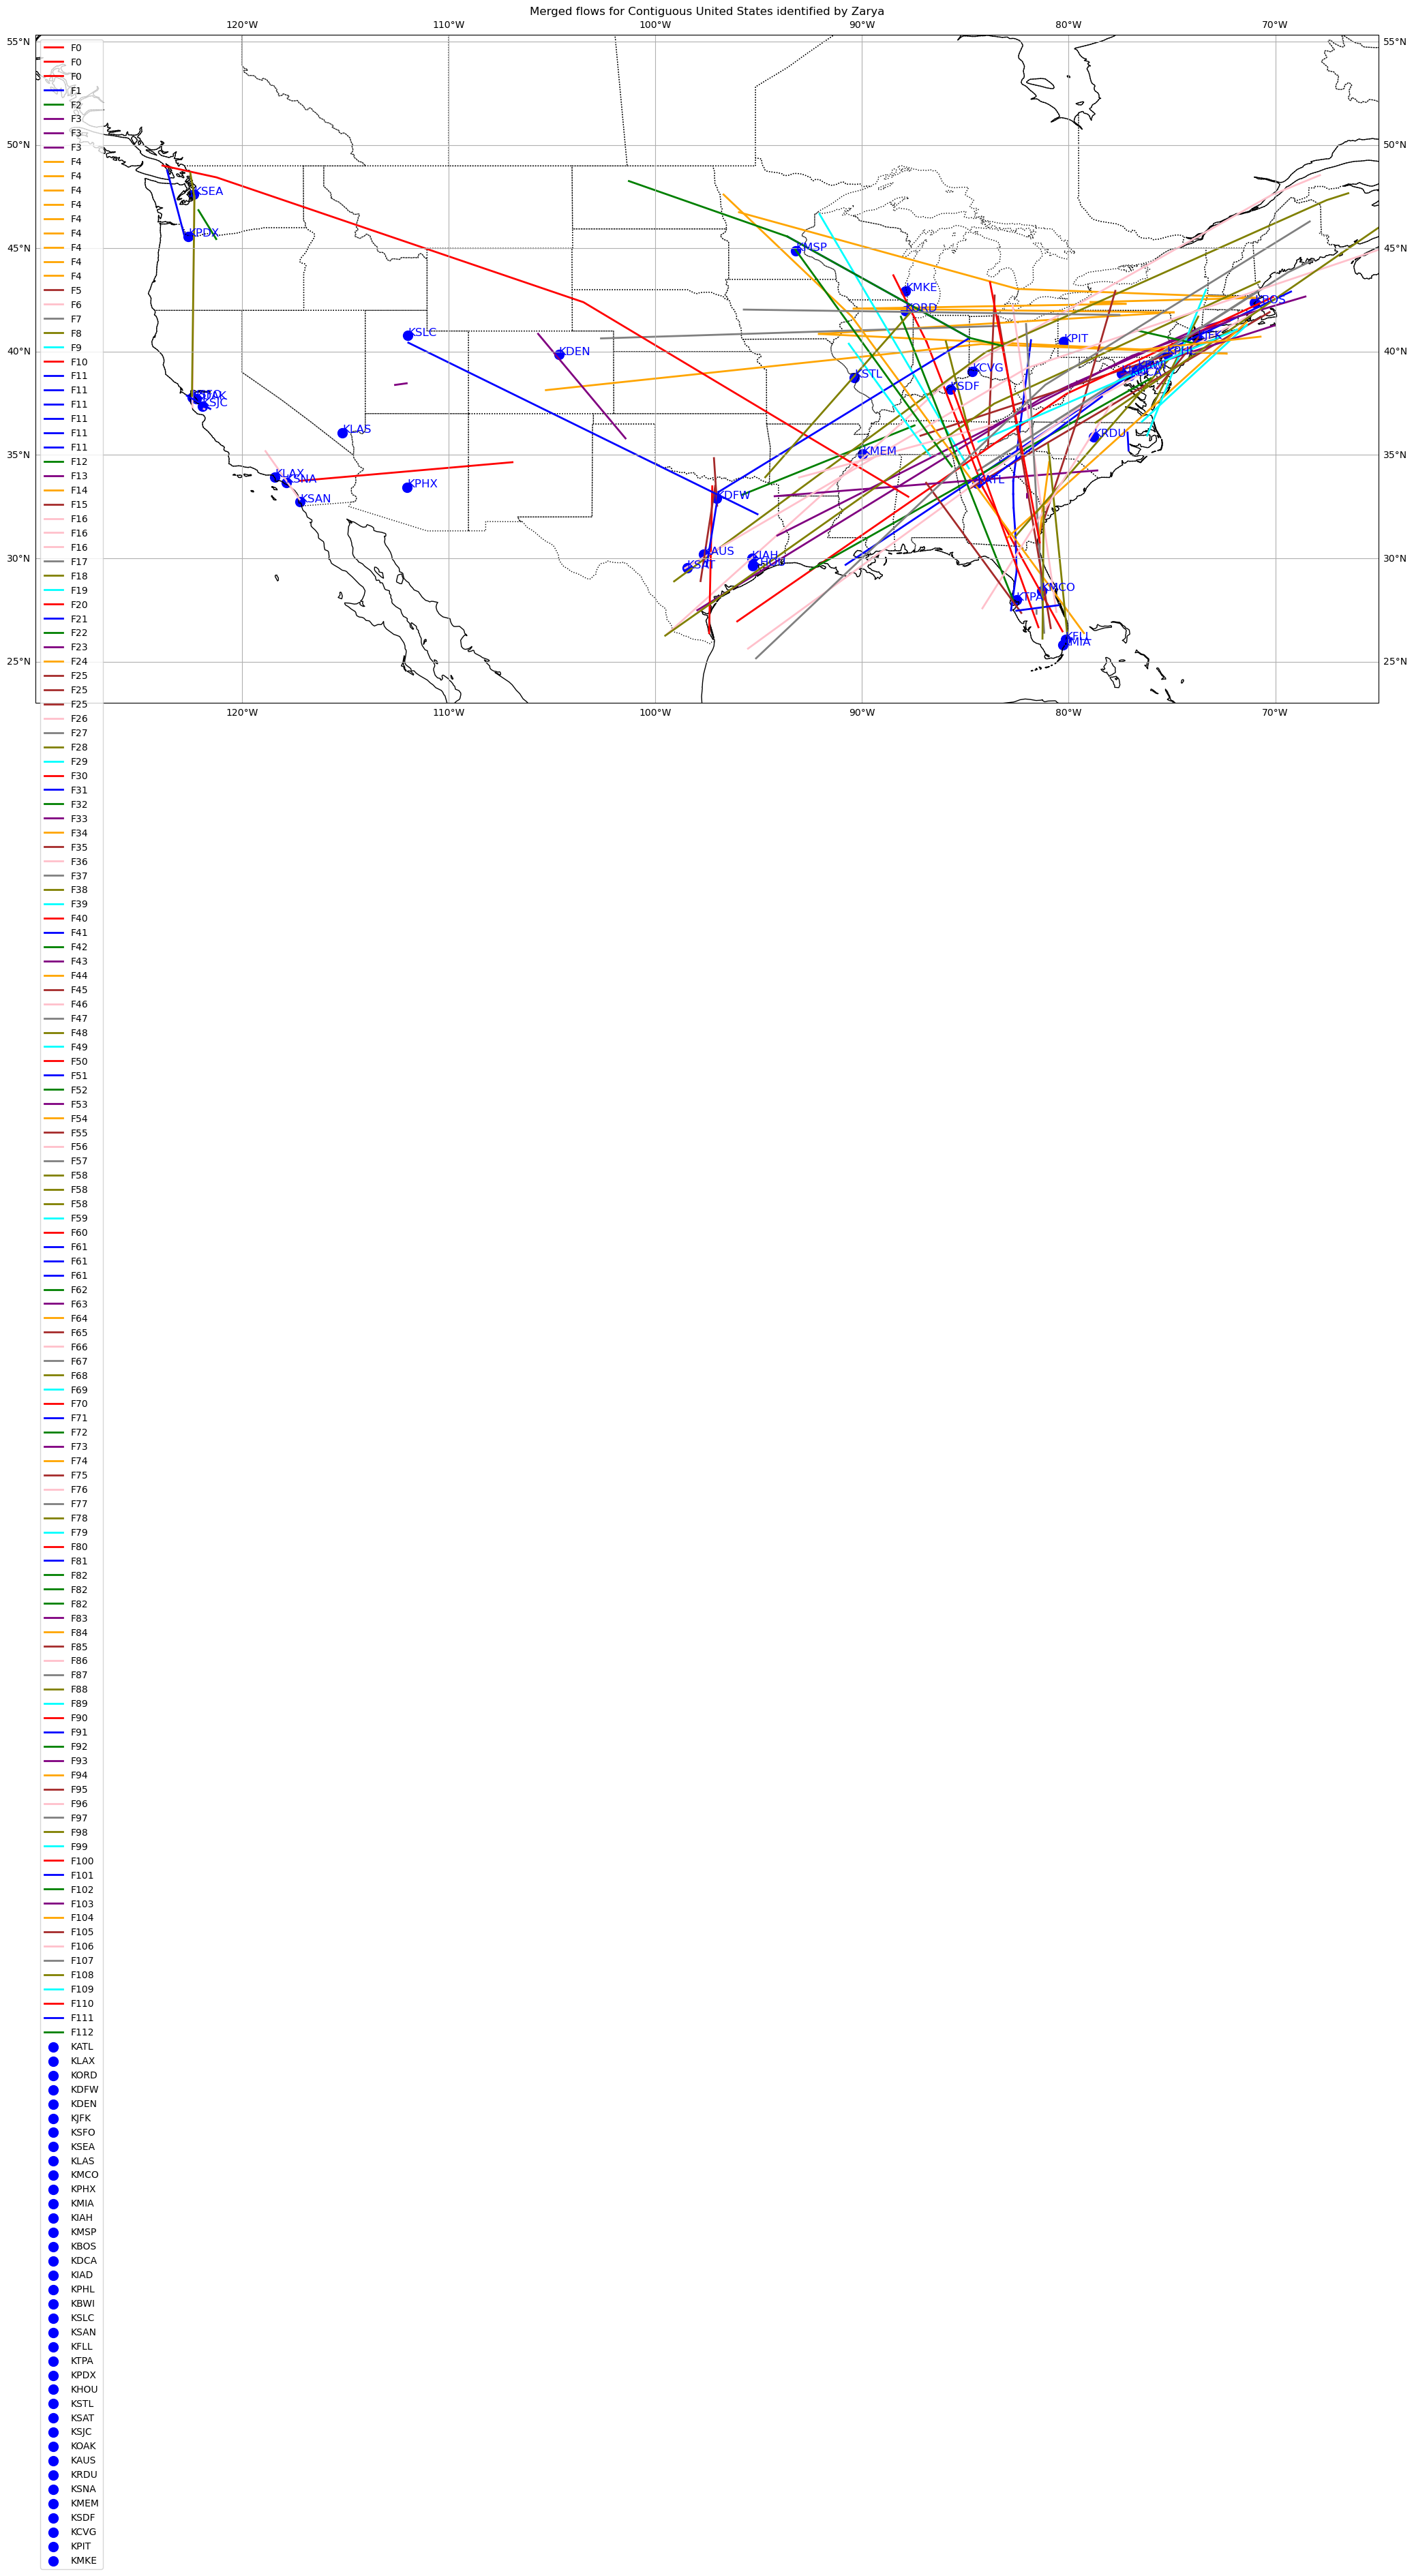

In [39]:
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.pyplot as plt
import mplcursors

def plot_merged_flows(merged_flows: list) -> None:
    # Create a Cartopy PlateCarree projection
    projection = ccrs.PlateCarree()

    # Create a figure
    fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})

    lat_bounds, lon_bounds = get_region_bounds('conus')

    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]])

    for i, flow in enumerate(merged_flows):
        # Plot the great circle going through sm_start and sm_end
        color = color_codes[i % len(color_codes)]
        if len(flow) > 1:
            for f in range(len(flow)-1):
                sm_start, sm_end = flow[f], flow[f+1]
                ax.plot([sm_start[1], sm_end[1]], [sm_start[0], sm_end[0]], color=color, linewidth=2, transform=ccrs.Geodetic(), label=f'F{i}')
        else:
            sm_start, sm_end = flow[0]
            ax.scatter(sm_start[1], sm_start[0], color=color, s=100, transform=ccrs.PlateCarree(), label=f'F{i}')
    # Add map features
    ax.coastlines()
    #ax.add_feature(cartopy.feature.OCEAN)
    #ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    ax.add_feature(cartopy.feature.STATES, linestyle=':')
    plt.title(f'Merged flows for Contiguous United States identified by Zarya')
    plt.tight_layout()
    # Set equal aspect ratio
    ax.set_aspect('equal', adjustable=None)
    # Show gridlines
    ax.gridlines(draw_labels=True)
    # Scatter plot the busiest airports
    for airport, data in busiest_airports.items():
        ax.scatter(data['lon'], data['lat'], color='blue', s=100, transform=ccrs.PlateCarree(), label=airport)
        ax.text(data['lon'], data['lat'], airport, transform=ccrs.PlateCarree(), fontsize=12, color='blue')
    # Add mplcursors to make it interactive
    cursor = mplcursors.cursor(hover=True)
    # Annotate with the legend label when hovering over a curve
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set_text(sel.artist.get_label())
    plt.legend()
    plt.show()

plot_merged_flows(merged_flows)

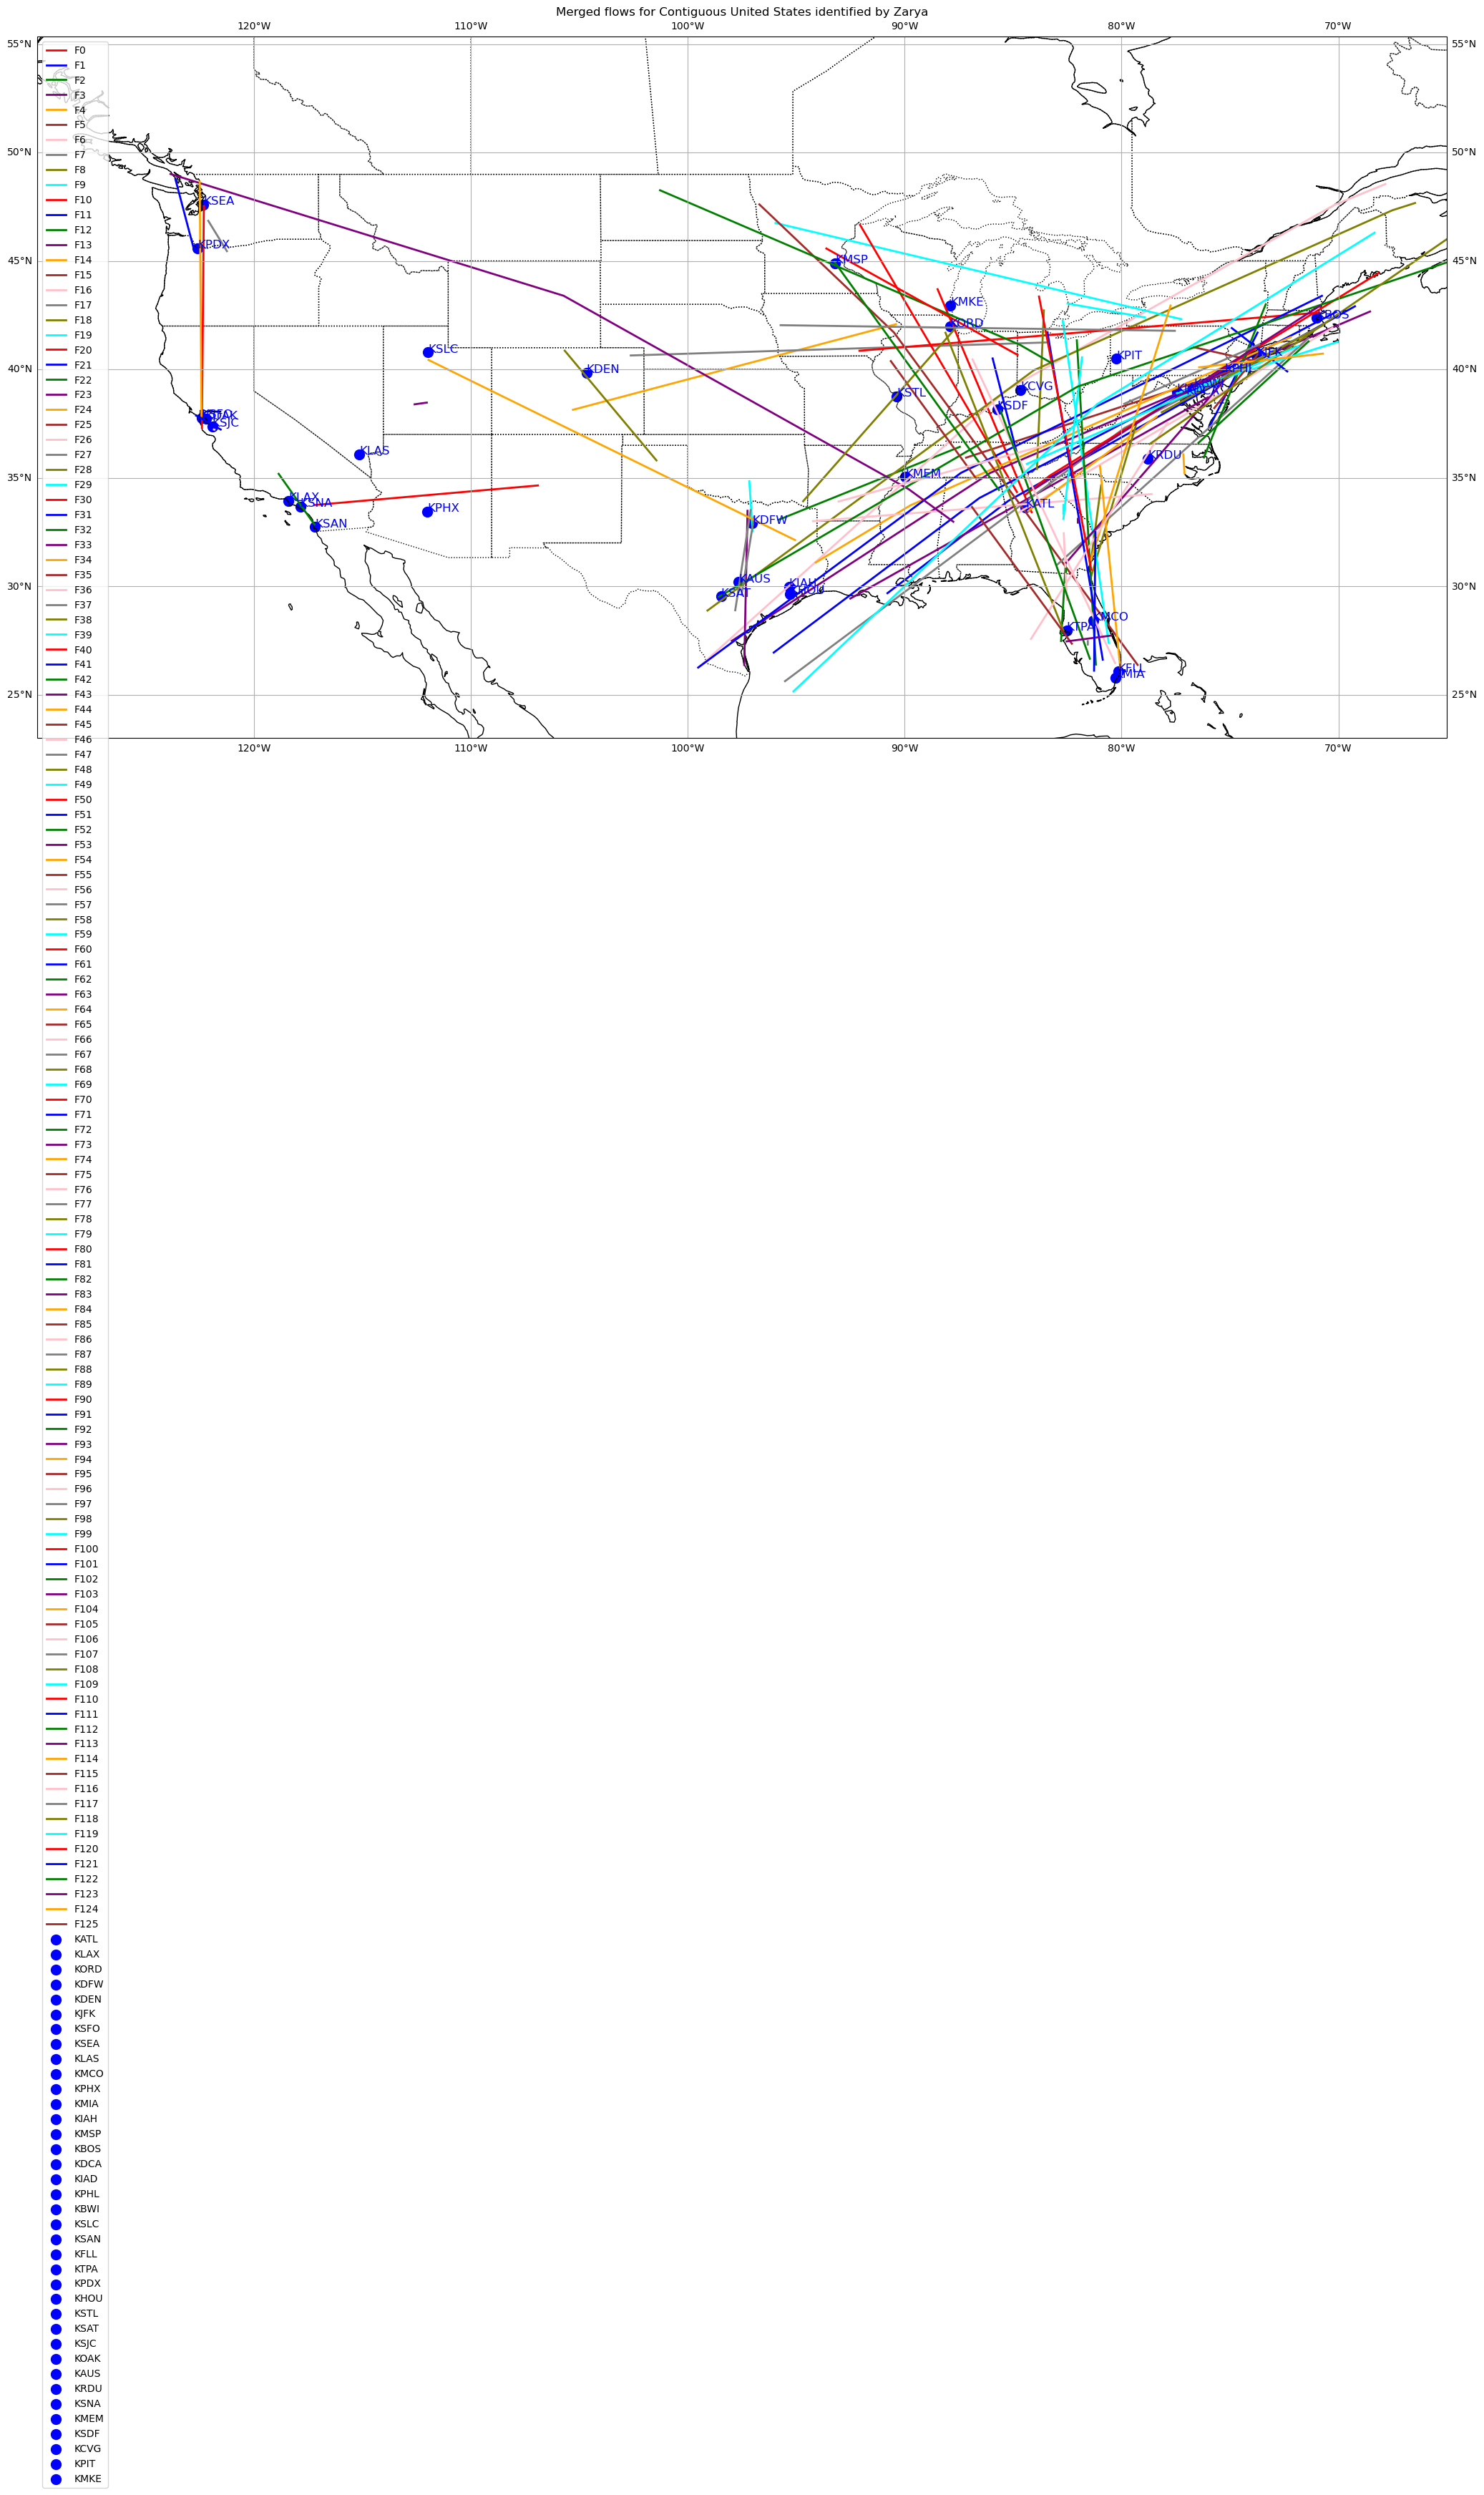

In [40]:
plot_merged_flows(flows)